Ciencia de Datos — TP2 (Grupo 15)

**Tema:** Histogramas, Kernels y Métodos No Supervisados con EPH  
**Archivos base (carpeta de trabajo `/mnt/data`):**
- `base_con_ad_equiv_por_hogar.xlsx` (base final TP1 — variables de interés)  
- `base respondieron.xlsx` (para reconstruir `pobre = ITF < ingreso_necesario`)  
- `basefinal.xlsx` (base general concatenada 2005 + 2025, si hace falta referenciar)  
- `2025 Diseño de registro y estructura para las bases preliminares (hogares y personas).pdf` (diccionario oficial INDEC)
- `TP2 TUTORIAL CIENCIA DE DATOS.pdf` (enunciado)

> Este notebook está listo para ejecutarse de arriba hacia abajo en Colab/Notebook local. Genera todas las figuras y estadísticas que pide el TP2 e incluye comentarios breves junto a cada salida.

# SETUP E IMPORTS

In [1]:
import os
import math
import json
from pathlib import Path
import numpy as np
import pandas as pd
# Mostrar números sin notación científica y con separador de miles
pd.options.display.float_format = '{:,.0f}'.format

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

# Configuración general de pandas / plots
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)
plt.rcParams.update({"figure.figsize": (7, 5), "axes.grid": True})
FIGDIR = Path("/mnt/data/figs")
FIGDIR.mkdir(parents=True, exist_ok=True)

from pathlib import Path
DATADIR = Path(".")  # en Colab trabajás en el directorio actual

# Carga de archivos

In [3]:
# Si estás en Colab, descomentá esta celda para subir los archivos manualmente.

from google.colab import files
import io

uploaded = files.upload()  # Aparece selector para subir varios archivos

# Guardamos en el entorno temporal de Colab
for fn, data in uploaded.items():
    with open(fn, "wb") as f:
        f.write(data)

print("Archivos cargados:", list(uploaded.keys()))

Saving base respondieron.xlsx to base respondieron.xlsx
Saving base_con_ad_equiv_por_hogar.xlsx to base_con_ad_equiv_por_hogar.xlsx
Saving basefinal.xlsx to basefinal.xlsx
Archivos cargados: ['base respondieron.xlsx', 'base_con_ad_equiv_por_hogar.xlsx', 'basefinal.xlsx']


In [4]:
FILES = {
  "base_tp1": DATADIR / "base_con_ad_equiv_por_hogar.xlsx",
    "respondieron": DATADIR / "base respondieron.xlsx",
    "basefinal": DATADIR / "basefinal.xlsx",
}

# Lectura de archivos

In [5]:
def read_any_excel(path):
  return pd.read_excel(path)

df_tp1 = read_any_excel(FILES["base_tp1"])
df_resp = read_any_excel(FILES["respondieron"])
df_basefinal = read_any_excel(FILES["basefinal"])

print("Shapes:")
for k, v in {"base_tp1": df_tp1, "respondieron": df_resp, "basefinal": df_basefinal}.items():
    shape = None if v is None else v.shape
    print(f"  {k}: {shape}")

# Copia de trabajo final del TP1
df = df_tp1.copy()
df.head(3)

Shapes:
  base_tp1: (16665, 20)
  respondieron: (13680, 20)
  basefinal: (16665, 244)


,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,P47T,PP04B_COD,PP07A,PP07C,MAS_500,CH03,ANIO,adulto_equiv,CODUSU,NRO_HOGAR,ad_equiv_hogar3
0,1,80,4,1,3,3,1,583,583,583,,0,0,S,1,2005,1,125098,1,1
1,1,26,2,4,4,1,0,150,450,450,5311,0,0,S,1,2005,1,125188,1,2
2,2,27,2,4,6,3,4,150,450,0,,0,0,S,2,2005,1,125188,1,2


# 1) VARIABLE EDAD2 y GRAFICOS DE EDAD

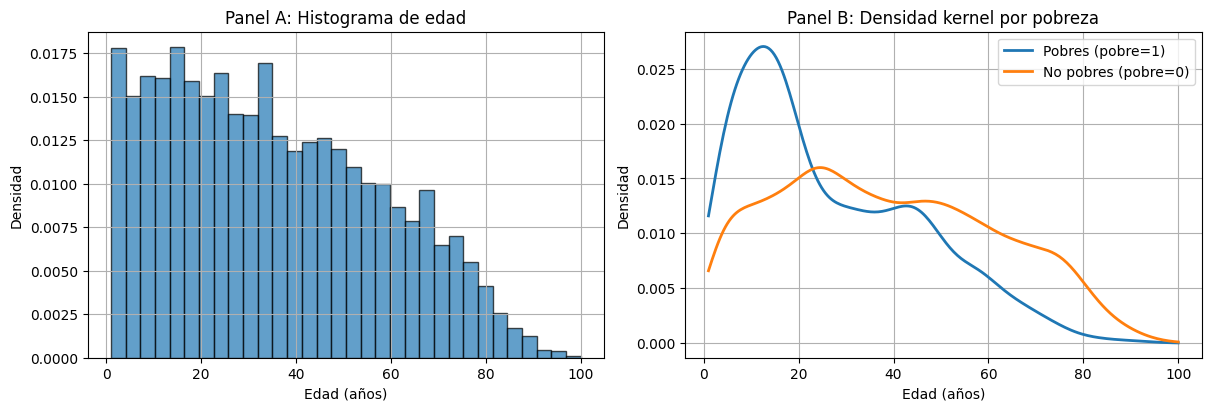

In [6]:
from scipy.stats import gaussian_kde

# --- 1) Limpiar edad y crear edad2 ---
# Asegurar que CH06 sea numérica
df_resp["CH06"] = pd.to_numeric(df_resp["CH06"], errors="coerce")

# Negativos -> NA
df_resp.loc[df_resp["CH06"] < 0, "CH06"] = np.nan

# Renombramos por comodidad
df_resp = df_resp.rename(columns={"CH06": "edad"})

# Crear edad2 (edad al cuadrado) respetando los NA
df_resp["edad2"] = df_resp["edad"] ** 2

# --- 2) Gráficos: Panel A (histograma) y Panel B (kernels por pobreza) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# Panel A: Histograma de edad
edad_valid = df_resp["edad"].dropna()
# Bins "inteligentes": entre 10 y 40 junto con regla de Freedman–Diaconis
def freedman_bins(x):
    if len(x) < 2:
        return 10
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    if iqr == 0:
        return 10
    bin_width = 2 * iqr * (len(x) ** (-1/3))
    if bin_width <= 0:
        return 10
    return int(np.clip((x.max() - x.min()) / bin_width, 10, 40))

bins = freedman_bins(edad_valid.to_numpy())

axes[0].hist(edad_valid, bins=bins, density=True, alpha=0.7, edgecolor="black")
axes[0].set_title("Panel A: Histograma de edad")
axes[0].set_xlabel("Edad (años)")
axes[0].set_ylabel("Densidad")

# Panel B: Densidades kernel por condición de pobreza
ax = axes[1]
ax.set_title("Panel B: Densidad kernel por pobreza")
ax.set_xlabel("Edad (años)")
ax.set_ylabel("Densidad")

# Subconjuntos
pobres = df_resp.loc[df_resp["pobre"] == 1, "edad"].dropna()
no_pobres = df_resp.loc[df_resp["pobre"] == 0, "edad"].dropna()

# Dominio común para evaluar densidades
if len(edad_valid) >= 2:
    x_grid = np.linspace(edad_valid.min(), edad_valid.max(), 250)
else:
    x_grid = np.linspace(0, 100, 250)  # fallback inocuo

# Función auxiliar para trazar KDE si hay datos suficientes
def plot_kde(series, label):
    if len(series) >= 2:
        kde = gaussian_kde(series.to_numpy())
        ax.plot(x_grid, kde(x_grid), label=label, linewidth=2)
    elif len(series) == 1:
        # Si hay un solo dato, mostrar una línea vertical tenue
        ax.axvline(series.iloc[0], linestyle="--", alpha=0.6, label=f"{label} (1 obs.)")
    else:
        # Sin datos
        pass

plot_kde(pobres, "Pobres (pobre=1)")
plot_kde(no_pobres, "No pobres (pobre=0)")

ax.legend()
plt.show()


# 2) Variable `educ` (años de educación) desde CH12/CH13/CH14 + descriptivos

In [8]:
MAX_EDUC = 30  # tope razonable (secundario 12, +terciario/univ/posgrado. 30 evita absurdos)

def calcular_educacion(row):
    ch12 = row.get('CH12')
    ch13 = row.get('CH13')
    ch14 = pd.to_numeric(row.get('CH14'), errors='coerce')  # último año aprobado dentro del nivel
    # Normalizo CH13 a booleano (1=Sí completó, 2/0/NaN=no)
    completo = (ch13 == 1)

    # Secundario
    if ch12 == 4:
        return 12 if completo else ch14

    # Terciario (asumimos 2–3 años típico)
    elif ch12 == 6:
        return 12 + (2 if completo else (ch14 if pd.notna(ch14) else np.nan))

    # Universitario (asumimos 4 años típico)
    elif ch12 == 7:
        return 12 + (4 if completo else (ch14 if pd.notna(ch14) else np.nan))

    # Posgrado (asumimos +2 años típico si completo; sino suma lo cursado dentro del posgrado)
    elif ch12 == 8:
        if completo:
            return 12 + 4 + 2
        else:
            # si no completó posgrado pero tiene base universitaria, sumo lo cursado
            base = 12 + 4
            return base + (ch14 if pd.notna(ch14) else np.nan)

    return np.nan

# Calcular educ y limpiar outliers
educ_series = df_basefinal.apply(calcular_educacion, axis=1)

# Forzar numérico y aplicar reglas: valores <0 o >MAX_EDUC -> NaN; luego clip por prolijidad
educ_series = pd.to_numeric(educ_series, errors='coerce')
educ_series = educ_series.where((educ_series >= 0) & (educ_series <= MAX_EDUC))
educ_series = educ_series.clip(lower=0, upper=MAX_EDUC)

# Guardar en df_resp (alineado por índice)
df_resp['educ'] = educ_series

# Estadísticas descriptivas
educ_stats = df_resp['educ'].describe()

educ_stats_df = educ_stats.to_frame().T.rename(columns={
    'count': 'Cantidad',
    'mean': 'Promedio',
    'std': 'Desviación Estándar',
    'min': 'Valor Mínimo',
    '50%': 'Mediana',
    'max': 'Valor Máximo'
})

educ_stats_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#f5f5f5'),
                                       ('color', 'black'),
                                       ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('background-color', '#fdfdfd')]}
])

,Cantidad,Promedio,Desviación Estándar,Valor Mínimo,25%,Mediana,75%,Valor Máximo
educ,7096.000000,10.454622,5.222780,0.000000,4.000000,12.000000,14.000000,21.000000


# 3) Ingreso total familiar (ITF) ajustado y gráficos con línea de pobreza

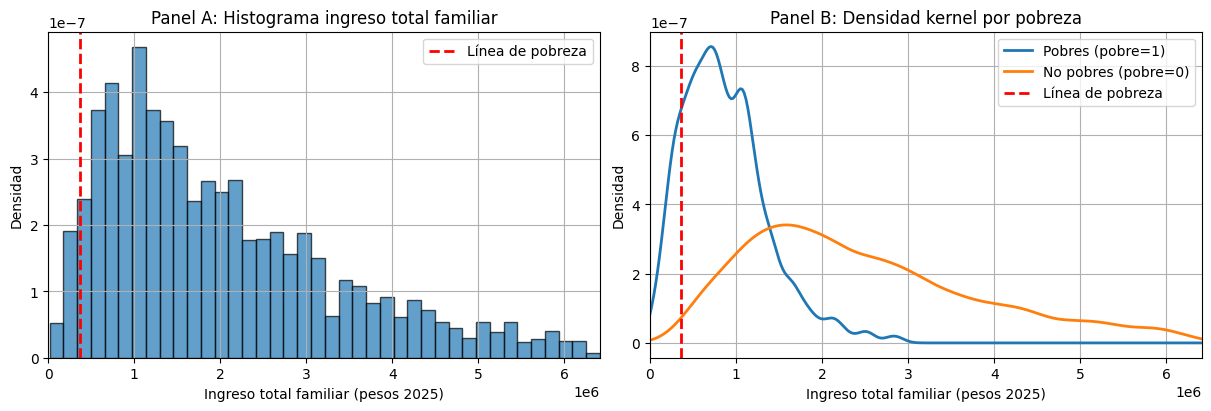

Recorte visual aplicado al percentil 95: x_max = 6,410,675 pesos de 2025


In [9]:
#formateo de eje X para que muestre los valores reales en pesos (sin notacion cientifica)
import matplotlib.ticker as mticker
for ax in axes:
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))

from scipy.stats import gaussian_kde

#1) Factor 2005 -> 2025 ---
canasta_2025 = 365177
canasta_2005 = 205.07
factor_2005_a_2025 = canasta_2025 / canasta_2005

# 2) Asegurar ITF ORIGINAL y numérico (IDEMPOTENTE) ---
df_resp["ITF"] = pd.to_numeric(df_resp["ITF"], errors="coerce")

# Guardar una copia inmutable del ITF original (solo si no existe)
if "ITF_original" not in df_resp.columns:
    df_resp["ITF_original"] = df_resp["ITF"]

#3) Ingreso total familiar a precios 2025 (NO modifica ITF) ---
df_resp["ingreso_total_familiar"] = np.where(
    df_resp["ANIO"] == 2005,
    df_resp["ITF_original"] * factor_2005_a_2025,
    df_resp["ITF_original"]
)

#4) Línea de pobreza (TP1, a pesos 2025) ---
linea_pobreza = canasta_2025

#5) Recorte visual al percentil 95 ---
ingresos_valid = df_resp["ingreso_total_familiar"].dropna()
x_max = np.nanpercentile(ingresos_valid, 95)

# Series recortadas (solo para visualización)
ingresos_clip = ingresos_valid[ingresos_valid <= x_max]
pobres_clip = df_resp.loc[df_resp["pobre"] == 1, "ingreso_total_familiar"].dropna()
pobres_clip = pobres_clip[pobres_clip <= x_max]
no_pobres_clip = df_resp.loc[df_resp["pobre"] == 0, "ingreso_total_familiar"].dropna()
no_pobres_clip = no_pobres_clip[no_pobres_clip <= x_max]

# Dominio común KDE
x_grid = np.linspace(0, x_max, 300)

#6) Gráficos ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# Panel A: Histograma
axes[0].hist(ingresos_clip, bins=40, density=True, alpha=0.7, edgecolor="black")
axes[0].set_xlim(0, x_max)
axes[0].set_title("Panel A: Histograma ingreso total familiar")
axes[0].set_xlabel("Ingreso total familiar (pesos 2025)")
axes[0].set_ylabel("Densidad")

if linea_pobreza <= x_max:
    axes[0].axvline(linea_pobreza, color="red", linestyle="--", linewidth=2, label="Línea de pobreza")
else:
    axes[0].annotate("Línea de pobreza fuera de rango",
                     xy=(x_max, axes[0].get_ylim()[1]*0.9),
                     xytext=(-10, 0), textcoords="offset points",
                     ha="right", va="center", fontsize=9, color="red")
axes[0].legend()

# Panel B: Densidades kernel por pobreza
ax = axes[1]
ax.set_title("Panel B: Densidad kernel por pobreza")
ax.set_xlabel("Ingreso total familiar (pesos 2025)")
ax.set_ylabel("Densidad")
ax.set_xlim(0, x_max)

def plot_kde(series, label):
    if len(series) >= 2:
        kde = gaussian_kde(series.to_numpy())
        ax.plot(x_grid, kde(x_grid), label=label, linewidth=2)
    elif len(series) == 1:
        ax.axvline(series.iloc[0], linestyle="--", alpha=0.6, label=f"{label} (1 obs.)")

plot_kde(pobres_clip, "Pobres (pobre=1)")
plot_kde(no_pobres_clip, "No pobres (pobre=0)")

if linea_pobreza <= x_max:
    ax.axvline(linea_pobreza, color="red", linestyle="--", linewidth=2, label="Línea de pobreza")
else:
    ax.annotate("Línea de pobreza fuera de rango",
                xy=(x_max, ax.get_ylim()[1]*0.9),
                xytext=(-10, 0), textcoords="offset points",
                ha="right", va="center", fontsize=9, color="red")
ax.legend()

plt.show()

print(f"Recorte visual aplicado al percentil 95: x_max = {x_max:,.0f} pesos de 2025")

#  4) `horastrab` del jefe de hogar (PP3E_TOT + PP3F_TOT) + descriptivos

In [18]:
#1) Calcular horas trabajadas en df_basefinal y pasarlas a df_resp ---
# Asegurar columnas PP3E_TOT y PP3F_TOT (si faltan, asumimos NaN)
#for col in ["PP3E_TOT", "PP3F_TOT"]:
#    if col not in df_basefinal.columns:
#        df_basefinal[col] = np.nan

# Pasar a numérico y marcar fuera de rango como NaN
for col in ["PP3E_TOT", "PP3F_TOT"]:
    df_basefinal[col] = pd.to_numeric(df_basefinal[col], errors="coerce")
    # Explicitly set values outside [0, 80] to NaN
    df_basefinal.loc[(df_basefinal[col] < 0) | (df_basefinal[col] > 80), col] = np.nan


# Crear columna de horas trabajadas totales:
# si alguna de las dos está en NaN → resultado será NaN
df_basefinal["horastrab"] = df_basefinal["PP3E_TOT"] + df_basefinal["PP3F_TOT"]

# Pasar resultado a df (alineado por índice)
df_resp["horastrab"] = df_basefinal["horastrab"]

#Volver a limpiar por si hay numeros que sumeran valor 84
df_basefinal.loc[df_basefinal["horastrab"] > 84, "horastrab"] = np.nan

#2) Identificar jefes/as de hogar y generar estadísticos ---
mask_jefe = pd.to_numeric(df_basefinal["CH03"], errors="coerce") == 1

desc_horas = df_basefinal.loc[mask_jefe, "horastrab"].describe(percentiles=[0.5]).rename({
    "count": "Cantidad",
    "mean": "Promedio",
    "std": "Desviación Estándar",
    "min": "Mínimo",
    "50%": "Mediana (p50)",
    "max": "Máximo"
})

# Convertir a DataFrame de 1 fila para mostrar en tabla
desc_horas_df = desc_horas.to_frame().T

# Mostrar como tabla bonita
desc_horas_df.style.set_table_styles([
    {"selector": "thead th", "props": [("background-color", "#f5f5f5"), ("font-weight", "bold")]},
    {"selector": "tbody td", "props": [("background-color", "#fdfdfd")]}
])

,Cantidad,Promedio,Desviación Estándar,Mínimo,Mediana (p50),Máximo
horastrab,4527.000000,29.061630,23.106431,0.000000,35.000000,84.000000


# 5) Tamaño base de nuestra región 1

In [19]:
# --- Funciones auxiliares ---
def contar_obs(df_like, year):
    return int(df_like.loc[df_like["ANIO"] == year].shape[0])

def contar_na_pobre(resp_like, year):
    sub = resp_like.loc[resp_like["ANIO"] == year, "pobre"]
    return int(sub.isna().sum())

def contar_pobres(resp_like, year):
    sub = resp_like.loc[resp_like["ANIO"] == year, "pobre"]
    return int((sub == 1).sum())

def contar_no_pobres(resp_like, year):
    sub = resp_like.loc[resp_like["ANIO"] == year, "pobre"]
    return int((sub == 0).sum())

# --- Años a considerar ---
years = [2005, 2025]

# --- Construcción de la tabla ---
rows = [
    "Cantidad de observaciones",
    "Cantidad de observaciones con NAs en la variable 'Pobre'",
    "Cantidad de Pobres",
    "Cantidad de No Pobres",
]

data = {}

# Datos por año
for y in years:
    co = contar_obs(df, y)
    na = contar_na_pobre(df_resp, y)
    pob = contar_pobres(df_resp, y)
    nop = contar_no_pobres(df_resp, y)
    data[y] = [co, na, pob, nop]

# Totales
co_total = sum(contar_obs(df, y) for y in years)
na_total = sum(contar_na_pobre(df_resp, y) for y in years)
pob_total = sum(contar_pobres(df_resp, y) for y in years)
nop_total = sum(contar_no_pobres(df_resp, y) for y in years)

data["Total"] = [co_total, na_total, pob_total, nop_total]

# --- DataFrame final ---
tabla1 = pd.DataFrame(data, index=rows)

# Mostrar la tabla
print("Tabla 1. Resumen de la base final para la región 1")
display(tabla1)

Tabla 1. Resumen de la base final para la región 1


,2005,2025,Total
Cantidad de observaciones,9484,7181,16665
Cantidad de observaciones con NAs en la variable 'Pobre',0,0,0
Cantidad de Pobres,2438,1334,3772
Cantidad de No Pobres,6933,2975,9908


# PARTE 2: METODOS NO SUPERVISADOS

# 1) Matriz de correlaciones (edad, edad2, educ, ITF, IX_TOT/IX_Tot, horastrab)

In [20]:
# Ver si df_resp tiene columna 'CODUSU' mergenado con df
if 'CODUSU' not in df_resp.columns:
    # Merge df's 'CODUSU' column into df_resp based on index
    df_resp = df_resp.merge(df[['CODUSU']], left_index=True, right_index=True, how='left')

# Creamos la variable "IX_TOT" (cantidad de personas en el hogar) en df_resp a partir de CODUSU
# Group by 'CODUSU' within df_resp itself
ix_tot_series = df_resp.groupby("CODUSU")["CODUSU"].transform("size")
df_resp["IX_TOT"] = ix_tot_series

# Verificamos rápido
print("Cantidad de hogares únicos:", df_resp["CODUSU"].nunique())

Cantidad de hogares únicos: 4435


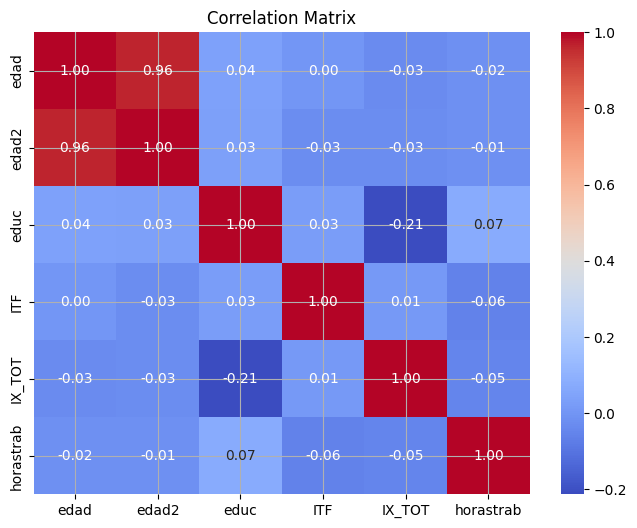

In [22]:
# Número de miembros en el hogar (IX_TOT / IX_Tot)
corr_cols = ["edad", "edad2", "educ", "ingreso_total_familiar", "IX_TOT", "horastrab"]

# Tomamos solo las columnas de interés y renombramos SOLO para la matriz
corr_df = (
    df_resp[corr_cols]
    .rename(columns={"ingreso_total_familiar": "ITF"})  # cambia solo en la copia
    .apply(pd.to_numeric, errors="coerce")
    .dropna()
)

# Calcular matriz de correlaciones
corr_mat = corr_df.corr()

# Graficar heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# A. PCA

# 2) PCA con ingreso.

Apliquen PCA a las seis variables seleccionadas para esta parte. Recuerde primero estandarizar las variables como vimos en la tutorial. En un gráfico de dispersión muestren los índices (scores) calculados del primer y segundo componente de PCA y comente los resultados.


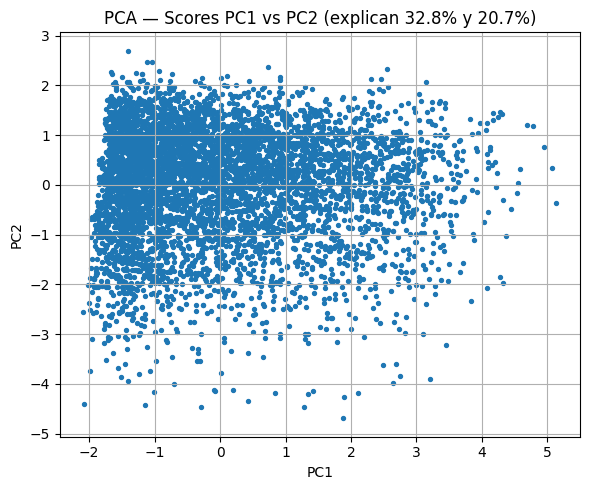

Varianza explicada por componente (%): [32.81 20.67 17.42 15.49 13.    0.62]
Varianza explicada acumulada (%):      [ 32.81  53.47  70.9   86.38  99.38 100.  ]


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Selección de variables
cols = ["edad", "edad2", "educ", "ingreso_total_familiar", "IX_TOT", "horastrab"]
faltan = [c for c in cols if c not in df_resp.columns]
assert not faltan, f"Faltan columnas en df_resp: {faltan}"

Z = df_resp[cols].apply(pd.to_numeric, errors="coerce")
X = Z.dropna(axis=0, how="any").values  # filas completas para PCA
keep_idx = Z.dropna(axis=0, how="any").index

# 2) Estandarización (z-scores)
Xz = StandardScaler().fit_transform(X)

# 3) PCA
pca = PCA(n_components=6, random_state=42)
scores = pca.fit_transform(Xz)             # coordenadas de observaciones
explained = pca.explained_variance_ratio_  # % varianza por PC
expl_cum = explained.cumsum()

# 4) Loadings (contribución de variables a cada PC)
#   (definición común: componentes * sqrt(varianza) -> magnitud comparable)
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    index=cols,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)])

# 5) Gráfico scores PC1 vs PC2
fig = plt.figure(figsize=(6,5))
plt.scatter(scores[:,0], scores[:,1], s=8)
plt.title(f"PCA — Scores PC1 vs PC2 (explican {explained[0]*100:.1f}% y {explained[1]*100:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 6) Mostrar varianza explicada y principales cargas
print("Varianza explicada por componente (%):", np.round(explained*100, 2))
print("Varianza explicada acumulada (%):     ", np.round(expl_cum*100, 2))


# 3) Graficos
3. Grafique con flechas los ponderadores (loading) de PCA para el primer y segundo componente y comente los pesos que que le dan a cada variable utilizada.


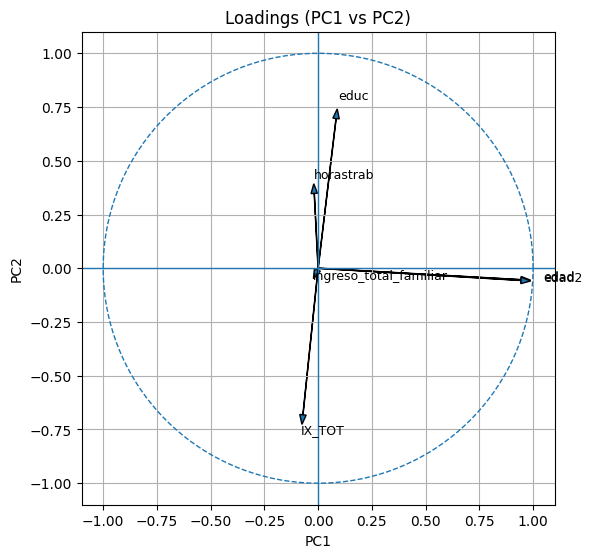

In [24]:
L = loadings[["PC1","PC2"]].to_numpy()
vars_ = loadings.index.tolist()

plt.figure(figsize=(6,6))
t = np.linspace(0, 2*np.pi, 300)
plt.plot(np.cos(t), np.sin(t), linestyle="--", linewidth=1)   # círculo unidad
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)

for (x, y), name in zip(L, vars_):
    x = np.clip(x, -1, 1); y = np.clip(y, -1, 1)
    plt.arrow(0, 0, x, y, head_width=0.03, length_includes_head=True)
    plt.text(x*1.06, y*1.06, name, fontsize=9)

plt.gca().set_aspect("equal", adjustable="box")
plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Loadings (PC1 vs PC2)")
plt.tight_layout(); plt.show()

# 4. Graficos varianza

Finalmente, grafique la proporción de la varianza explicada para cada uno de los seis componentes y comente el gráfico.


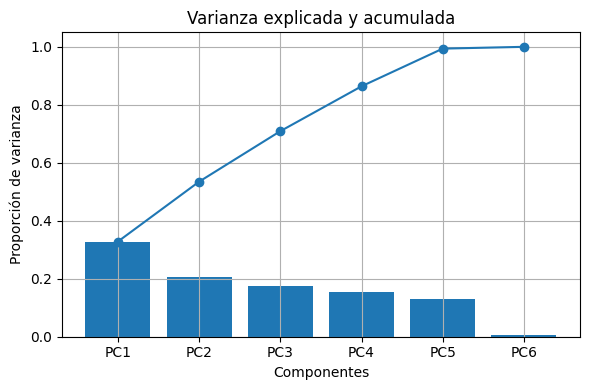

PC1: 32.81% | PC2: 20.67% | Acum PC1–PC2: 53.47%


In [25]:
evr = explained  # ya calculado
xs = np.arange(1, len(evr)+1)

plt.figure(figsize=(6,4))
plt.bar(xs, evr)
plt.plot(xs, evr.cumsum(), marker="o")
plt.xticks(xs, [f"PC{i}" for i in xs])
plt.xlabel("Componentes"); plt.ylabel("Proporción de varianza")
plt.title("Varianza explicada y acumulada")
plt.tight_layout(); plt.show()

print(f"PC1: {evr[0]:.2%} | PC2: {evr[1]:.2%} | Acum PC1–PC2: {evr[:2].sum():.2%}")

# B. Cluster

# 5)Cluster k-medias:
a. Corran el algoritmo con 𝑘 = 2, 𝑘 = 4 y 𝑘 = 10 usando n_init =20, y grafiquen los resultados usando dos edad e ingreso familiar. Interprétenlos ¿Puede el algoritmo con 𝑘 = 2 separar correctamente a las personas pobres y no pobres en su región?

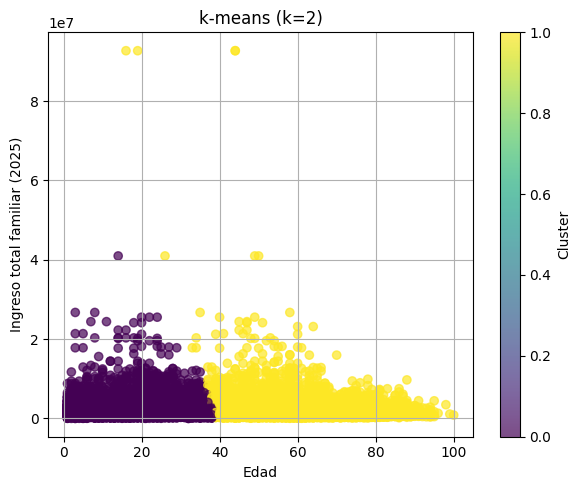

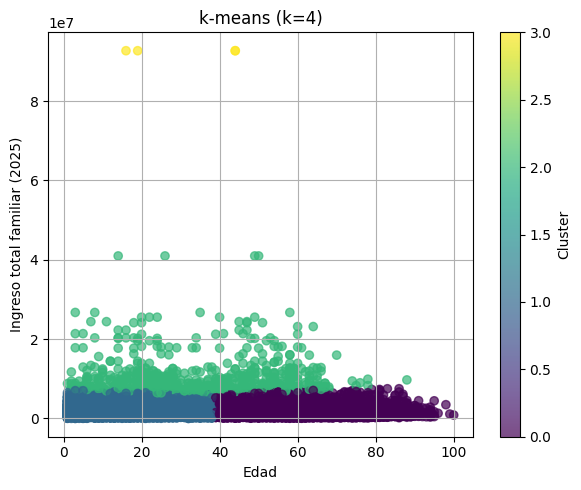

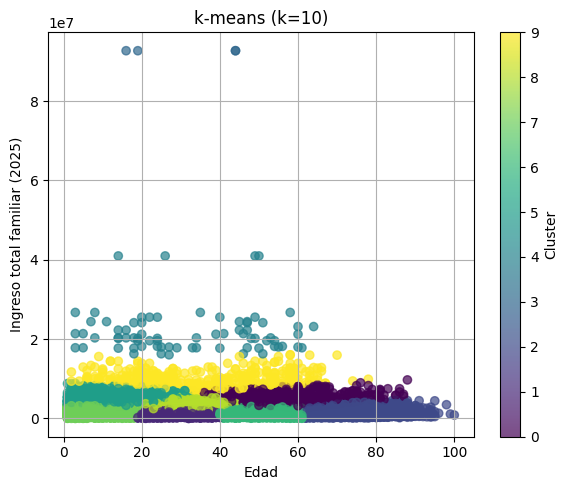

pobre,0,1
kmeans_k2,,
0,5107,2681
1,4700,1031


,no_pobre(0),pobre(1)
kmeans_k2,,
0,0.656,0.344
1,0.820,0.180


In [26]:
# Tomamos solo las columnas necesarias y limpiamos
tmp = df_resp[['edad', 'ingreso_total_familiar', 'pobre']].dropna().copy()
tmp['pobre'] = tmp['pobre'].astype(int)

X = tmp[['edad', 'ingreso_total_familiar']].to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenamos para k=2, 4, 10
for k in (2, 4, 10):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    tmp[f'kmeans_k{k}'] = km.fit_predict(X_scaled)
    df_resp.loc[tmp.index, f'kmeans_k{k}'] = tmp[f'kmeans_k{k}']

# Función simple de gráfico
def plot_clusters(data, label_col, k):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(data['edad'], data['ingreso_total_familiar'],
                     c=data[label_col], alpha=0.7)
    plt.xlabel('Edad')
    plt.ylabel('Ingreso total familiar (2025)')
    plt.title(f'k-means (k={k})')
    plt.colorbar(sc, label='Cluster')
    plt.tight_layout()
    plt.show()

for k in (2, 4, 10):
    plot_clusters(tmp, f'kmeans_k{k}', k)

# Conteos + proporciones (con decimales)
cont = pd.crosstab(tmp['kmeans_k2'], tmp['pobre'])          # conteos reales
prop = cont.div(cont.sum(axis=1), axis=0)                   # proporciones por fila (suman 1)
prop.columns = ['no_pobre(0)', 'pobre(1)']

display(cont)                                               # tabla de conteos
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(prop)                                           # tabla de proporciones con decimales


# 5B)
Grafique alguna medida de disimilitud para 𝑘 = 1 hasta 𝑘 = 10. Usando la inspección visual de Elbow ¿cuál sería el número óptimo de clusters en su región? ¿Dicha cantidad de grupos nos ayudaría a distinguir entre pobres y no pobres o entre distintas clases socioeconómicas?

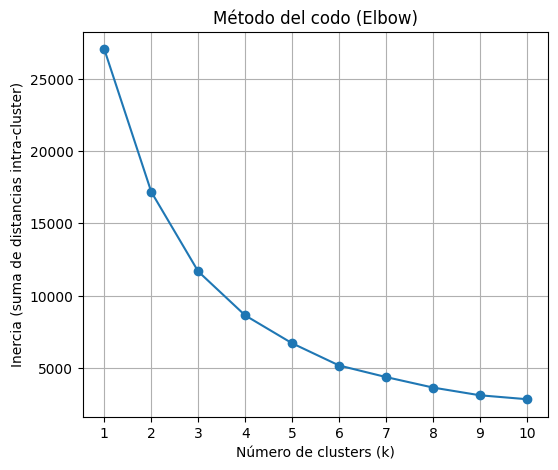

In [27]:
# 5.b) Método del codo para k=1..10

tmp = df_resp[['edad', 'ingreso_total_familiar']].dropna().copy()
X = tmp[['edad', 'ingreso_total_familiar']].to_numpy()
X_scaled = StandardScaler().fit_transform(X)

inertias = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (suma de distancias intra-cluster)')
plt.title('Método del codo (Elbow)')
plt.xticks(K)
plt.grid(True)
plt.show()


# 6)
Cluster jerárquico: Utilizando las variables mencionadas arriba, realicen un análisis de clustering jerárquico. Generen un dendograma y expliquen brevemente qué es un dendograma.

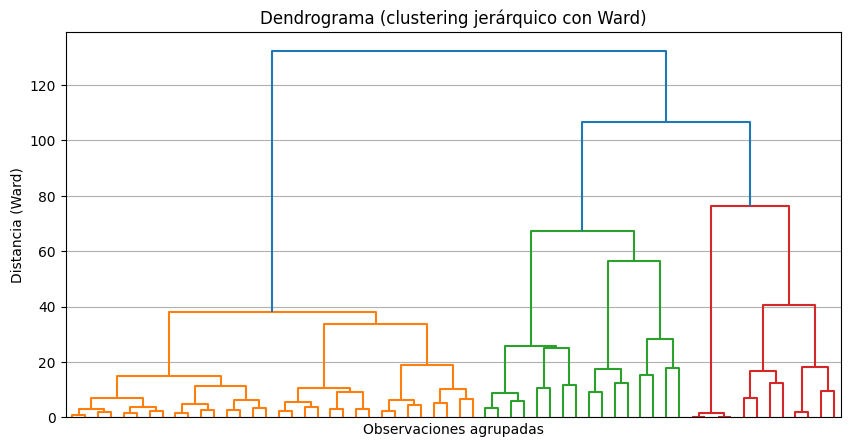

In [28]:
# 6) Clustering jerárquico + dendrograma

tmp = df_resp[['edad', 'ingreso_total_familiar']].dropna().copy()
X = tmp[['edad', 'ingreso_total_familiar']].to_numpy()
X_scaled = StandardScaler().fit_transform(X)

# Clustering jerárquico (método ward)
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5, no_labels=True)
plt.title('Dendrograma (clustering jerárquico con Ward)')
plt.xlabel('Observaciones agrupadas')
plt.ylabel('Distancia (Ward)')
plt.show()
